In [1]:
import sys
sys.path.append("../../../src")

from mask_dataset import MaskedDataset
from mask_dataset import MaskedDataset
from probe_evaluation import draw_active_neuron_heatmap
from prober import Prober
import numpy as np

dataset = MaskedDataset(model_name='mbert')
prober = Prober(dataset, device='cuda:5')

Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-mbert/mlama-dataset.pkl for MaskedDataset instance


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
# Find uuid shared by en, af and ja
from pred_evaluation import get_full_match_matrix_by_uuid
langs, all_uuids, matrix = get_full_match_matrix_by_uuid(dataset)
# cand_langs = ['en', 'de', 'id', 'ms']
cand_langs = ['en', 'pl']

ids = [langs.index(lang) for lang in cand_langs]
uuids = [
    all_uuids[idx]
    for idx in np.where(matrix[ids].sum(axis=0)==4)[0]]

for uuid in uuids:
    print(uuid, dataset.uuid_info_plain[uuid]['rel_uri'], dataset.display_uuid(uuid))


In [43]:
# P1001, P47, P159
lang1, lang2 = 'en', 'pl'
available_rels = []
for rel in ['P176']:
    sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
    sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
    if probing_en[3] != None and probing_da[3] != None:
        common_uuids = list(set(probing_en[3].keys()).intersection(set(probing_da[3].keys())))
        if len(common_uuids) > 0:
            print(rel, len(common_uuids))
            available_rels.append(rel)

# for uuid in common_uuids[:5]:
#     print(uuid, dataset.uuid_info_plain[uuid]['rel_uri'], dataset.display_uuid(uuid))

P176 533


In [44]:
from scipy.stats import spearmanr, kendalltau
from tqdm import tqdm 

def measure_neuron_similarity(neuron_rank1, neuron_rank2, topk=50, method='shared_neuron'):
    neuron_rank1 = neuron_rank1[:topk]
    neuron_rank2 = neuron_rank2[:topk]
    if method == "shared_neuron":
        corr = len(set(neuron_rank1).intersection(set(neuron_rank2))) / len(set(neuron_rank1).union(set(neuron_rank2)))
    elif method == "spearmanr":
        corr, _ = spearmanr(neuron_rank1, neuron_rank2)
    elif method == "kendalltau":
        corr, _ = kendalltau(neuron_rank1, neuron_rank2)
    return corr

uuid2score = {}
for rel in tqdm(available_rels):
    sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
    sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
    common_uuids = list(set(probing_en[3].keys()).intersection(set(probing_da[3].keys())))

    topk = 50
    for uuid in common_uuids:
        # if 'Google' not in dataset.display_uuid(uuid, 'zh'):
        #     continue
        top_neuron_en = probing_en[1][uuid]
        top_neuron_da = probing_da[1][uuid][:topk]
        sim12 = measure_neuron_similarity(top_neuron_en, top_neuron_da)
        uuid2score[uuid] = (sim12, rel) 
sorted_uuid2score = sorted(uuid2score.items(), key=lambda x: x[1][0], reverse=True)

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


In [28]:
for uuid, (score, rel) in sorted_uuid2score[:10]:
    top_neuron_en = probing_en[1][uuid]
    top_neuron_da = probing_da[1][uuid][:topk]
    print(f"{measure_neuron_similarity(top_neuron_en, top_neuron_da):.2f}",
          uuid, dataset.display_uuid(uuid))

KeyError: 'b98678e3-e8ea-43c5-834c-53aeee99e7cc'

In [ ]:
topk = 50
for uuid in common_uuids:
    top_neuron_en = set(probing_en[1][uuid][:topk])
    top_neuron_da = set(probing_da[1][uuid][:topk])
    top_neuron_id = set(probing_id[1][uuid][:topk])
    top_neuron_ms = set(probing_ms[1][uuid][:topk])
    print(uuid, dataset.display_uuid(uuid),
        len(top_neuron_en.intersection(top_neuron_da)),
        len(top_neuron_id.intersection(top_neuron_ms)),
        len(top_neuron_en.intersection(top_neuron_id)),
        len(top_neuron_en.intersection(top_neuron_ms)))

393c6f1c-c67a-42fc-847c-0581bda8a970 The headquarter of Chinese Academy of Sciences is in Beijing . 31 24 22 23
4d633787-ea73-4118-9951-f58141f9950c The headquarter of Standard Chartered is in London . 29 30 24 22
7d997732-3280-4eb1-ac23-e0e99211bc40 The headquarter of EMI is in London . 36 35 25 24
582603cf-b8ce-4048-8bcc-3894f0e1e486 The headquarter of Euronext Amsterdam is in Amsterdam . 27 30 16 19
7a3ae086-be9a-4ee9-8bdb-d71721be83c3 The headquarter of The Manila Times is in Manila . 30 28 25 20
88d970aa-b7eb-47cc-9891-68b2154147cf The headquarter of University of Paris is in Paris . 29 28 21 11
1f4b8544-d99b-49fc-85aa-14f2fce79f7b The headquarter of Royal Australian Air Force is in Canberra . 36 34 25 21
2ed94dfe-207e-4147-aee3-20a86475c53e The headquarter of Bayerischer Rundfunk is in Munich . 23 27 21 23
58e1e850-8ac0-4afc-ab42-7e626a78fdf2 The headquarter of Karolinska Institute is in Stockholm . 24 29 20 23
f50b6f57-0c07-4acf-8cb0-af4aeb9c14c7 The headquarter of Communist Par

In [45]:
sorted_uuid2score[:10]

[('115dcbca-77ae-48d0-aac2-9af0417b7652', (0.4492753623188406, 'P176')),
 ('bbb9fc8a-6208-4316-8be3-17d1d36cdb42', (0.42857142857142855, 'P176')),
 ('89431918-7e17-47b9-9086-c2842fac161c', (0.4084507042253521, 'P176')),
 ('284495b2-61d0-4c6f-bbd4-d3cd13c71753', (0.4084507042253521, 'P176')),
 ('ae27c303-e8ff-4679-af6b-d15cf01cd3ea', (0.3698630136986301, 'P176')),
 ('6d431782-13d1-4aa7-b156-e9b4530d5262', (0.3698630136986301, 'P176')),
 ('eda4d35c-9c4b-450b-bbcc-d2b4cc7912a2', (0.3698630136986301, 'P176')),
 ('1c692b83-fb02-43c7-8212-1fc3a1b95f68', (0.3698630136986301, 'P176')),
 ('f90fac17-6b5e-4d65-bddb-40547421b922', (0.3698630136986301, 'P176')),
 ('9256b0ee-a6e0-495b-b118-51a7b9fd2351', (0.3698630136986301, 'P176'))]

Ferrari Daytona is produced by Ferrari .
Ferrari Daytona jest wytwarzany przez Ferrari.


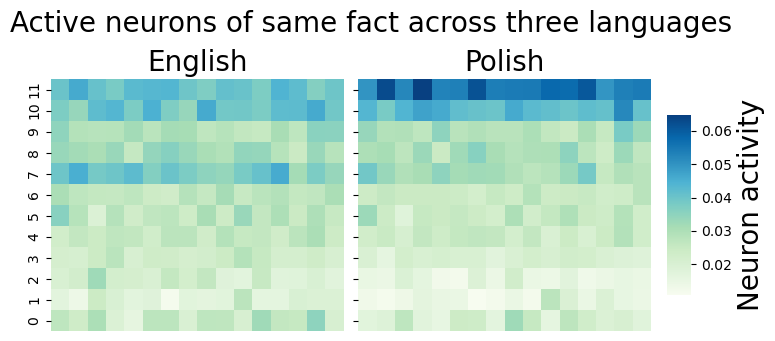

Honda Logo is produced by Honda .
Honda Logo jest wytwarzany przez Honda.


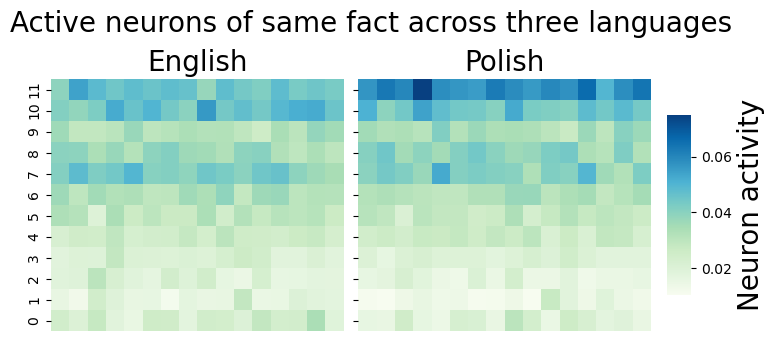

Douglas X-3 Stiletto is produced by Douglas .
Douglas X-3 Stiletto jest wytwarzany przez Douglas.


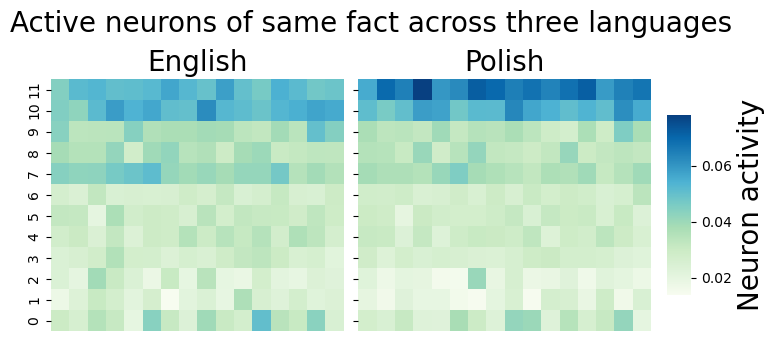

Intel MCS-48 is produced by Intel .
Intel MCS-48 jest wytwarzany przez Intel.


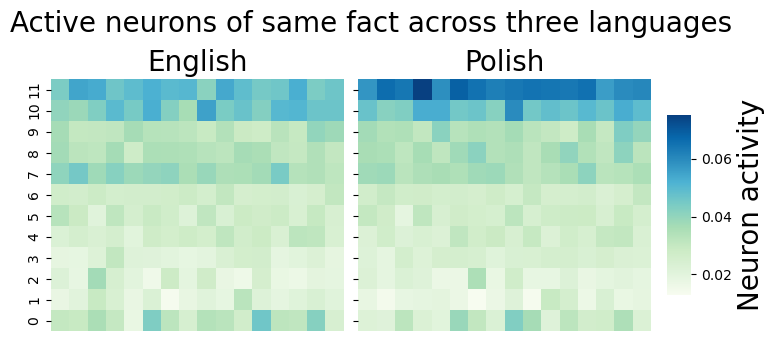

Boeing KC-46 is produced by Boeing .
Boeing KC-46 jest wytwarzany przez Boeing.


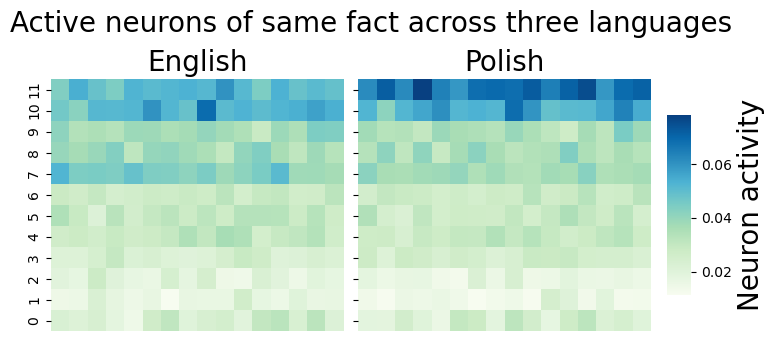

Bentley Continental GT is produced by Bentley .
Bentley Continental GT jest wytwarzany przez Bentley.


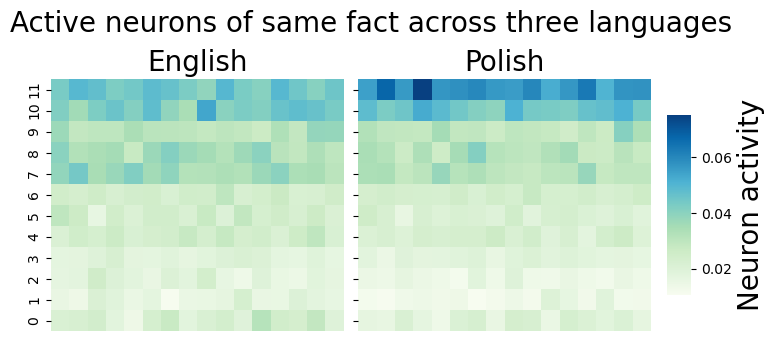

Ferrari 550 is produced by Ferrari .
Ferrari 550 jest wytwarzany przez Ferrari.


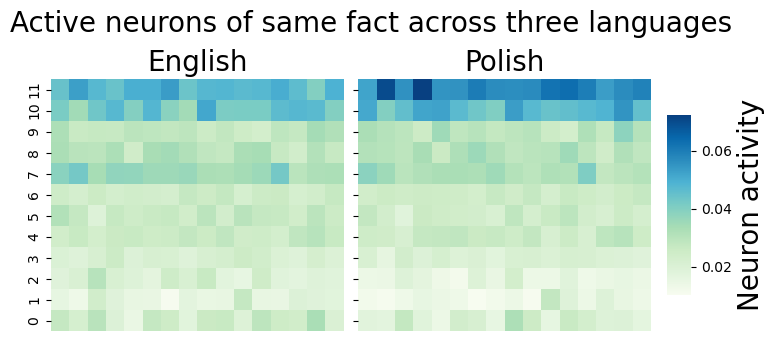

B-47 Stratojet is produced by Boeing .
Boeing B-47 Stratojet jest wytwarzany przez Boeing.


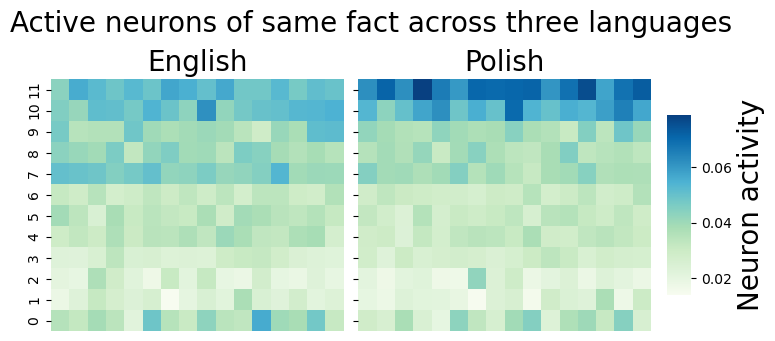

Ferrari 212 Inter is produced by Ferrari .
Ferrari 212 Inter jest wytwarzany przez Ferrari.


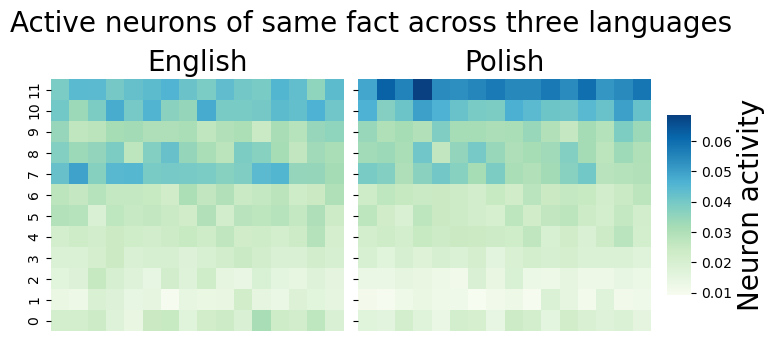

Chevrolet Corvette (C4) is produced by Chevrolet .
Chevrolet Corvette ZR-1 jest wytwarzany przez Chevrolet.


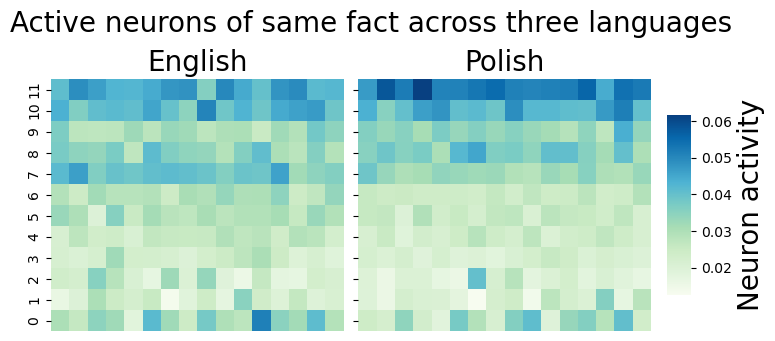

Chevrolet Corvette C6 is produced by Chevrolet .
Chevrolet Corvette C6 Z06 jest wytwarzany przez Chevrolet.


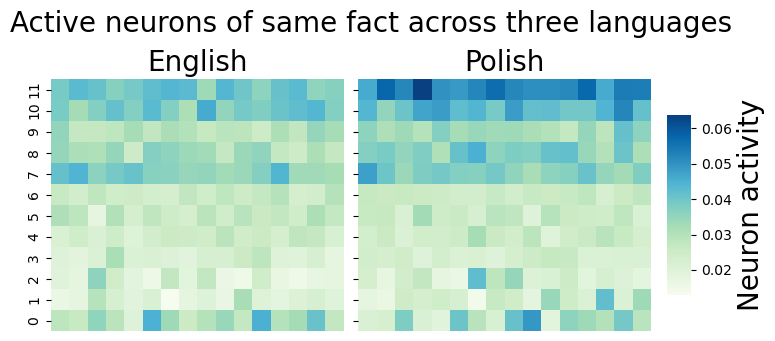

Intel 8008 is produced by Intel .
Intel 8008 jest wytwarzany przez Intel.


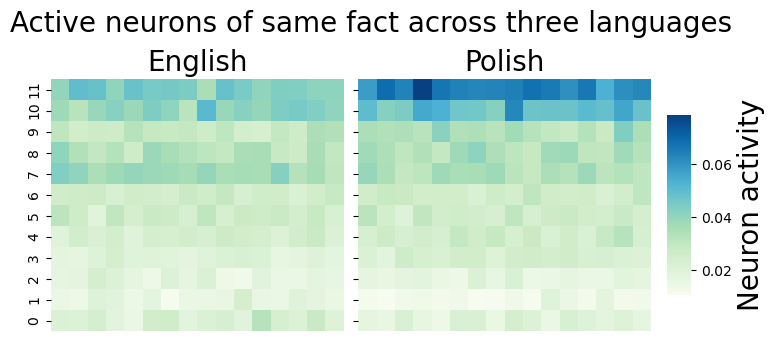

Ferrari 195 Inter is produced by Ferrari .
Ferrari 195 Inter jest wytwarzany przez Ferrari.


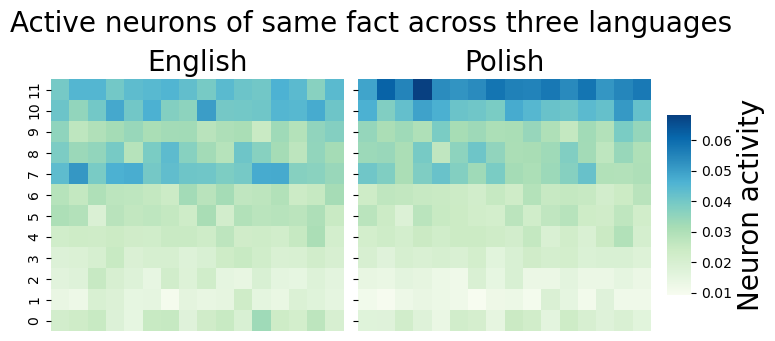

Windows Phone 8.1 is produced by Microsoft .
Windows Phone 8.1 jest wytwarzany przez Microsoft.


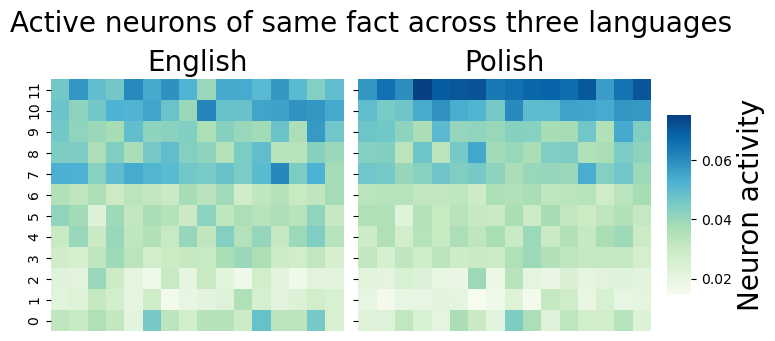

Windows 7 is produced by Microsoft .
Windows 7 jest wytwarzany przez Microsoft.


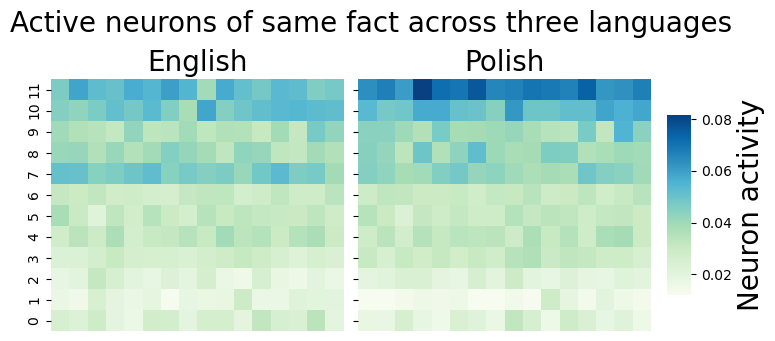

Suzuki Alto is produced by Suzuki .
Suzuki Alto jest wytwarzany przez Suzuki.


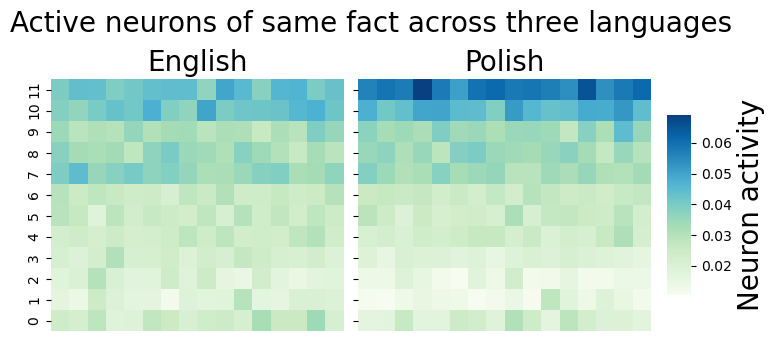

Porsche 911 GT2 is produced by Porsche .
Porsche 911 GT2 jest wytwarzany przez Porsche.


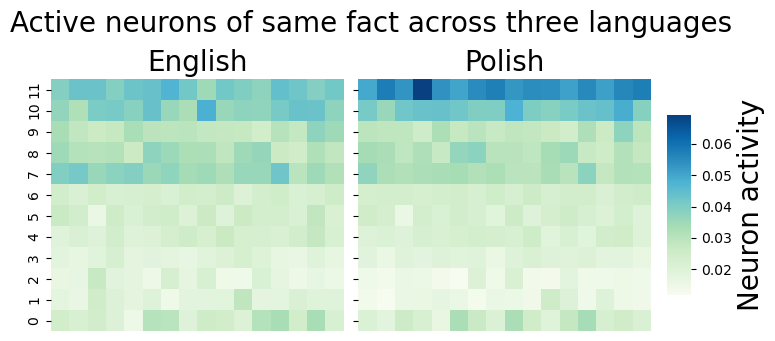

Renault Vel Satis is produced by Renault .
Renault Vel Satis jest wytwarzany przez Renault.


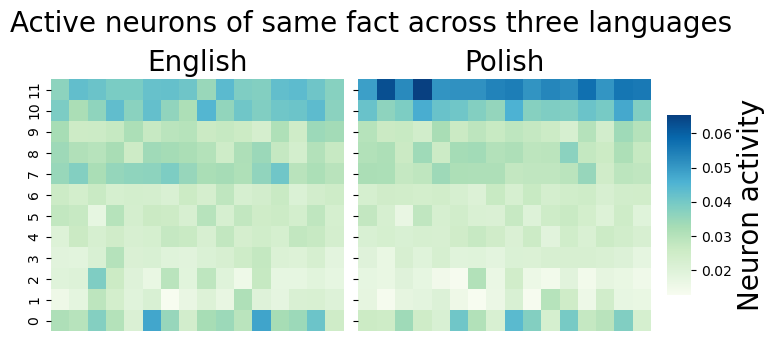

Ferrari 575M Maranello is produced by Ferrari .
Ferrari 575M Maranello jest wytwarzany przez Ferrari.


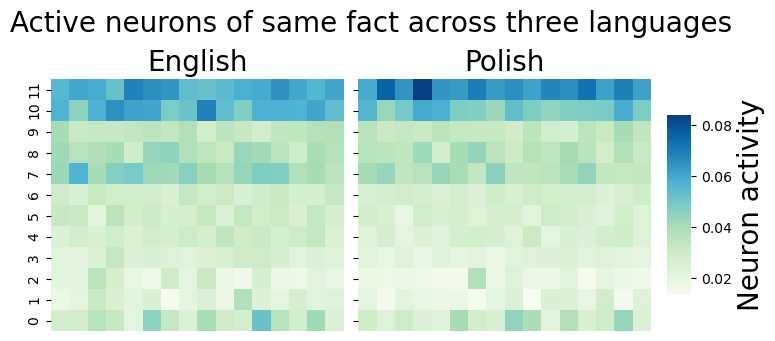

Boeing 777 is produced by Boeing .
Boeing 777 jest wytwarzany przez Boeing.


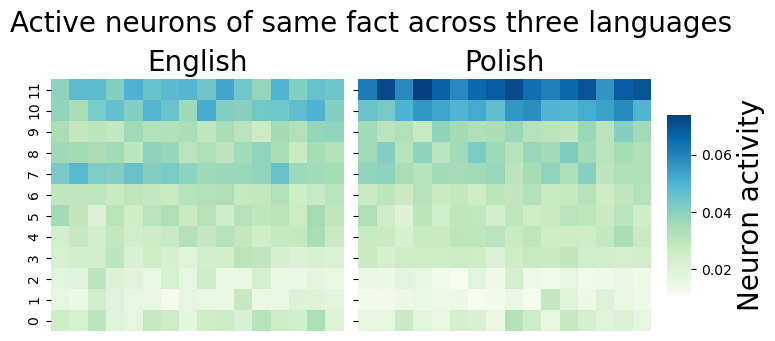

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

for uuid, (score, rel) in sorted_uuid2score[:20]:
    layer_num = 12
    # rel = "P176"
    # uuid = "cb0a2a89-9694-443e-9604-0dd760dcb6ff"
    sorted_uuids_en, ranked_uuids_en, probing_en = prober.probe_uuid_by_lang_rel(lang1, rel, cand_size=10000)
    sorted_uuids_da, ranked_uuids_da, probing_da = prober.probe_uuid_by_lang_rel(lang2, rel, cand_size=10000)
    top_neuron_en = probing_en[1][uuid]
    top_neuron_da = probing_da[1][uuid][:topk]
    print(dataset.display_uuid(uuid, lang1))
    print(dataset.display_uuid(uuid, lang2))

    uuid, dataset.display_uuid(uuid)

    neurons1 = probing_en[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)
    neurons2 = probing_da[3][uuid].reshape(layer_num, -1, 16).mean(axis=1)

    
    plt.rcParams['ps.useafm'] = True
    plt.rcParams['pdf.use14corefonts'] = True
    langs = [dataset.display_lang(lang,prefix=False) for lang in [lang1, lang2]]
    fig, axn = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3))

    vmin = min(map(np.min, [neurons1, neurons2]))
    vmax = max(map(np.max, [neurons1, neurons2]))
    cbar_ax = fig.add_axes([.87, .2, .03, .6])
    axn_flat = axn.flatten()

    # Loop over data, axis, and attributions to plot heatmaps
    for i, (ax, lang) in enumerate(zip(axn_flat, langs)):
        # sns.heatmap(data=[neurons1, neurons2, neurons3, neurons4][i], ax=ax, cmap='GnBu')
        sns.heatmap(data=[neurons1, neurons2][i], ax=ax, cmap='GnBu', cbar=i == 0, cbar_ax=None if i else cbar_ax, vmin=vmin, vmax=vmax)
        ax.set_title(lang, fontsize=20)  # Changed from set_xlabel to set_title for correct labeling
        # ax.set_xlabel(lang, fontsize=20)
        ax.set_xticks([])
        # ax.set_yticks([])
        ax.invert_yaxis()
    cbar_ax.set_ylabel('Neuron activity', fontsize=20)
    # fig.text(0.5, 0, 'Neurons in each layer (chunked into 16 blocks)', ha='center', va='center', fontsize=15)
    # fig.text(0.04, 0.5, 'Transformer layers', ha='center', va='center', rotation='vertical', fontsize=20)
    # fig.text(.23, -0.04, 'William Pitt the Younger\n used to work in London .', ha='center', fontsize=12)
    # fig.text(.47, -0.04, 'William Pitt der Jüngere\n arbeitete früher in London.', ha='center', fontsize=12)
    # fig.text(.73, -0.04, 'William Pitt yang Muda\n dulu bekerja di London.', ha='center', fontsize=12)
    fig.suptitle("Active neurons of same fact across three languages", fontsize=20, y=1.15)

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.1, right=0.85, hspace=0.1, wspace=0.05)
    plt.show()